# Testing DeepER

### Import libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import seaborn as sns
from deeper_model import build_model
from deeper_utils import preprocess_data

Using TensorFlow backend.


### Read the dataset

In [2]:
trainData, testData, valData, embeddingMatrix, wordsWithNoEmbeddings = preprocess_data(
    'DBLP-ACM', baseDir = '../input/deeper/deeper', maxSequenceLength=100)

Printing out words with no embeddings in GloVe

In [3]:
PRINT_RANGE = 30

if len(wordsWithNoEmbeddings) < PRINT_RANGE:
    PRINT_RANGE = len(wordsWithNoEmbeddings)

if PRINT_RANGE > 0:   
    for i in range(PRINT_RANGE):
        print(wordsWithNoEmbeddings[i])

print('...')
print("There are {} words with no embeddings in GloVe".format(len(wordsWithNoEmbeddings)))

sigmod
vldb
ramakrishnan
surajit
seshadri
suciu
divesh
kyuseok
kriegel
aberer
lakshmanan
garofalakis
abiteboul
florescu
hellerstein
silberschatz
pirahesh
haritsa
ioannidis
moerkotte
faloutsos
sarawagi
chakrabarti
jayavel
shanmugasundaram
gehrke
shekita
viswanath
poosala
syan
...
There are 2196 words with no embeddings in GloVe


Print embedding matrix shape

In [4]:
embeddingMatrix.shape

(7850, 300)

In [5]:
leftTableTrainData, rightTableTrainData, trainLabels = trainData
leftTableTestData, rightTableTestData, testLabels = testData
leftTableValData, rightTableValData, valLabels = valData

Print training set size

In [6]:
print(leftTableTrainData.shape)
print(rightTableTrainData.shape)

(7417, 100)
(7417, 100)


Print test set size

In [7]:
print(leftTableTestData.shape)
print(rightTableTestData.shape)

(2473, 100)
(2473, 100)


Print validation set size

In [8]:
print(leftTableValData.shape)
print(rightTableValData.shape)

(2473, 100)
(2473, 100)


### Build the DeepER model 

In [9]:
model = build_model(embeddingMatrix, lstmUnits=75, lstm_dropout=0.1, mask_zero=True, maxSequenceLength=100)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     2355000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150)          225600      embedding_1[0][0]                
          

### Plot DeepER architecture

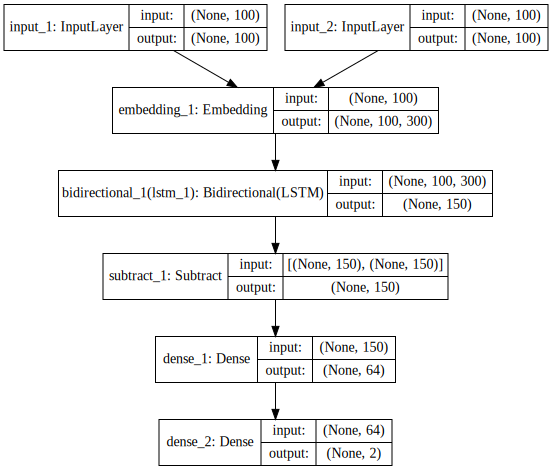

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Training

In [11]:
start_time = time.time()

history = model.fit([leftTableTrainData,
           rightTableTrainData],
          trainLabels,
          batch_size=256,
          epochs=20,
          validation_data=([leftTableValData,
                            rightTableValData],
                           valLabels))

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Train on 7417 samples, validate on 2473 samples
Epoch 1/20
7417/7417 [==============================] - 95s 13ms/step - loss: 0.4753 - acc: 0.8067 - val_loss: 0.3806 - val_acc: 0.8205
Epoch 2/20
7417/7417 [==============================] - 92s 12ms/step - loss: 0.3083 - acc: 0.8277 - val_loss: 0.2024 - val_acc: 0.9163
Epoch 3/20
7417/7417 [==============================] - 91s 12ms/step - loss: 0.1650 - acc: 0.9405 - val_loss: 0.1109 - val_acc: 0.9753
Epoch 4/20
7417/7417 [==============================] - 92s 12ms/step - loss: 0.0842 - acc: 0.9811 - val_loss: 0.0740 - val_acc: 0.9786
Epoch 5/20
7417/7417 [==============================] - 88s 12ms/step - loss: 0.0435 - acc: 0.9930 - val_loss: 0.0560 - val_acc: 0.9798
Epoch 6/20
7417/7417 [==============================] - 88s 12ms/step - loss: 0.0277 - acc: 0.9950 - val_loss: 0.0597 - val_acc: 0.9794
Epoch 7/20
7417/7417 [==============================] - 88s 12ms/step - loss: 0.0216 - acc: 0.9947 - val_loss: 0.0534 - val_acc: 0.9806


### Plot accuracy and loss

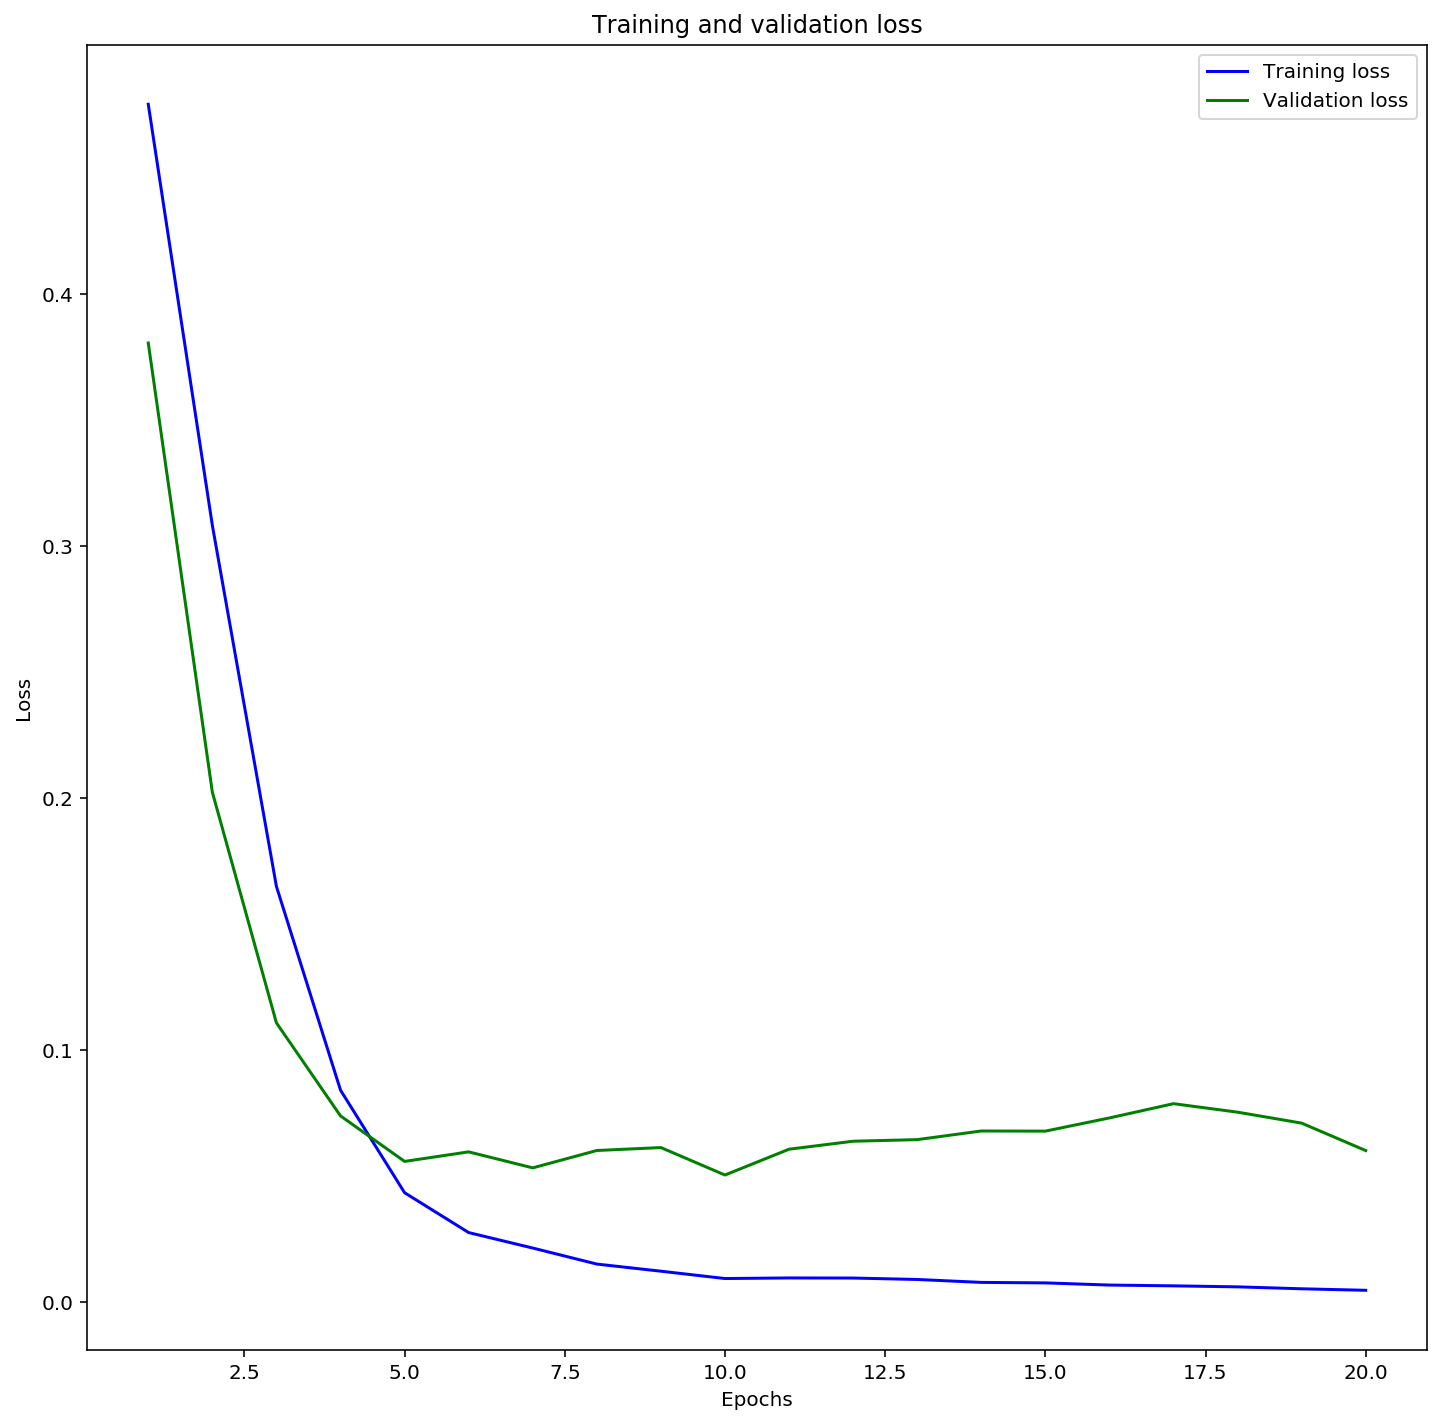

In [12]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

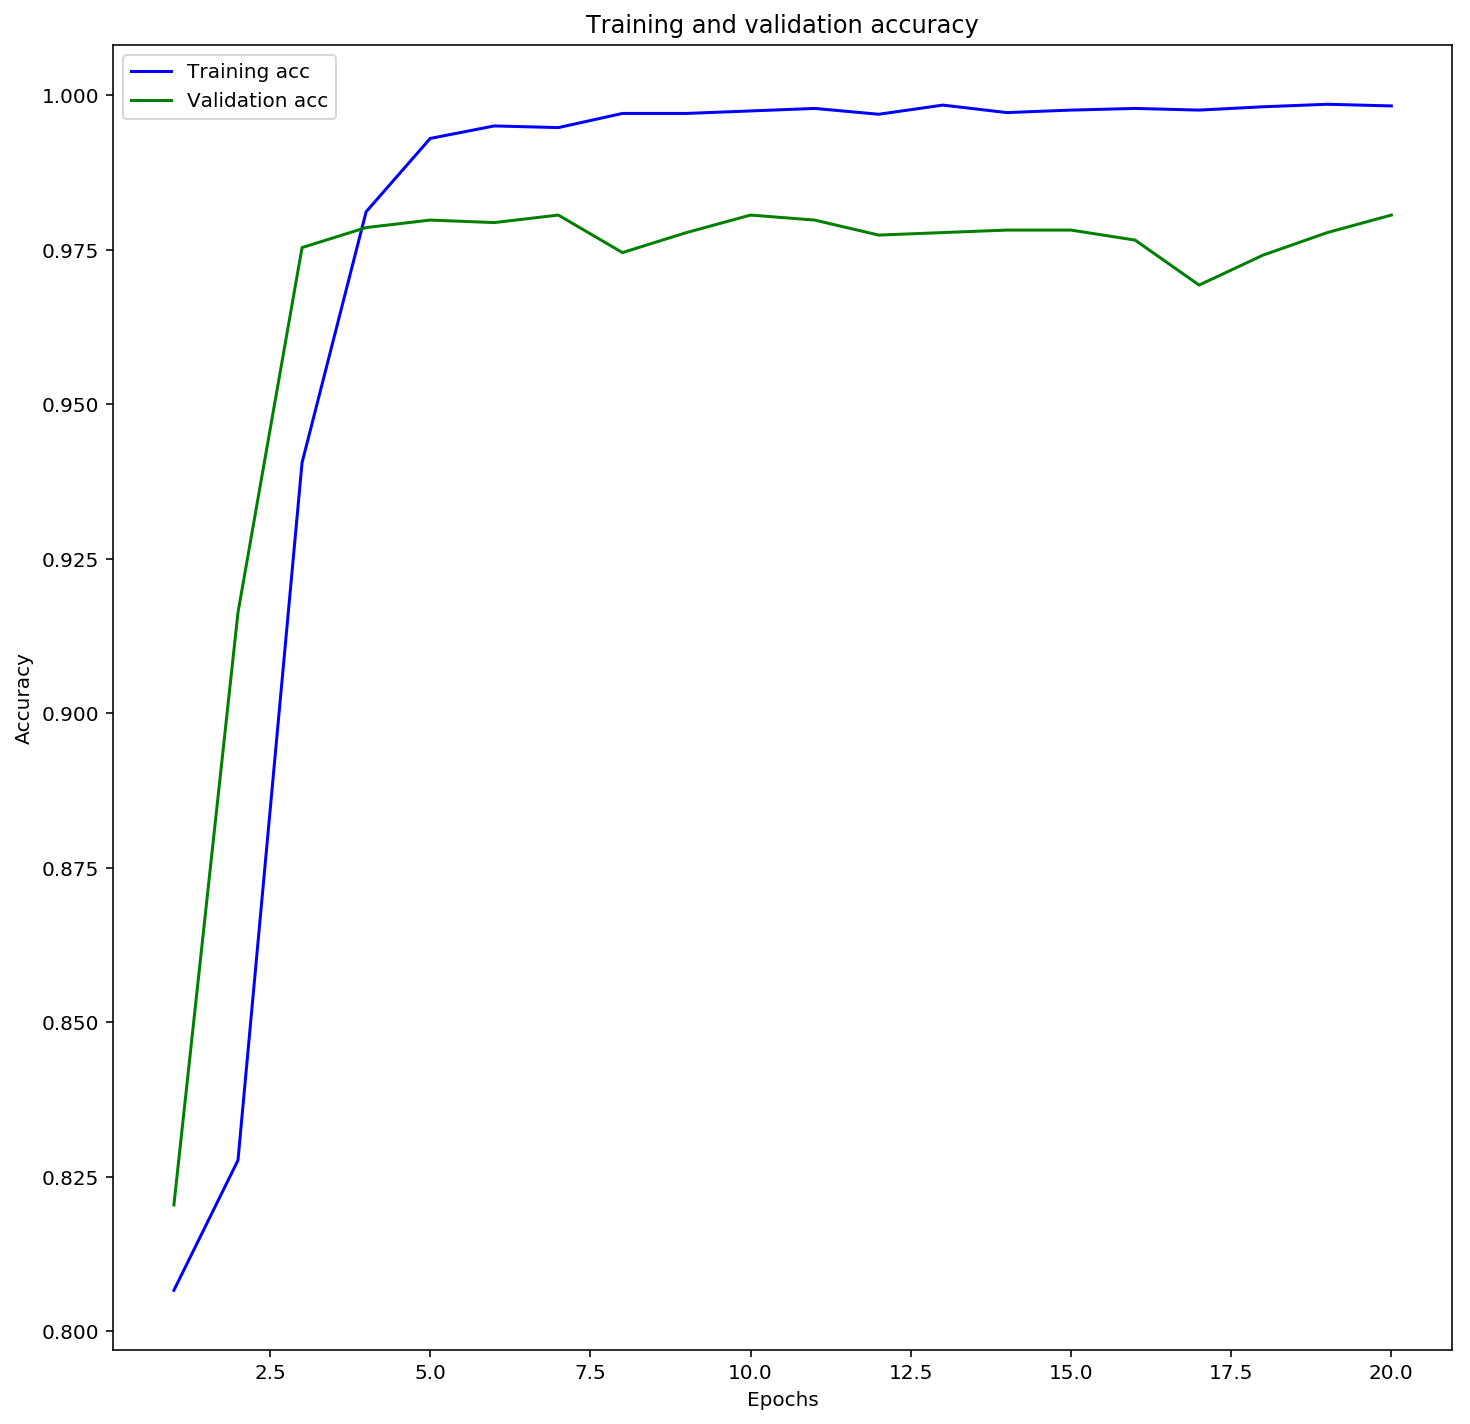

In [13]:
plt.figure(figsize=(12,12))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Predict labels on test data

In [14]:
predictedLabels = model.predict(x=[leftTableTestData, rightTableTestData])
predictedLabels = predictedLabels.argmax(axis=1)
testLabels = testLabels.argmax(axis=1)

### Compute confusion matrix

[Text(0, 0.5, 'non matching'), Text(0, 1.5, 'matching')]

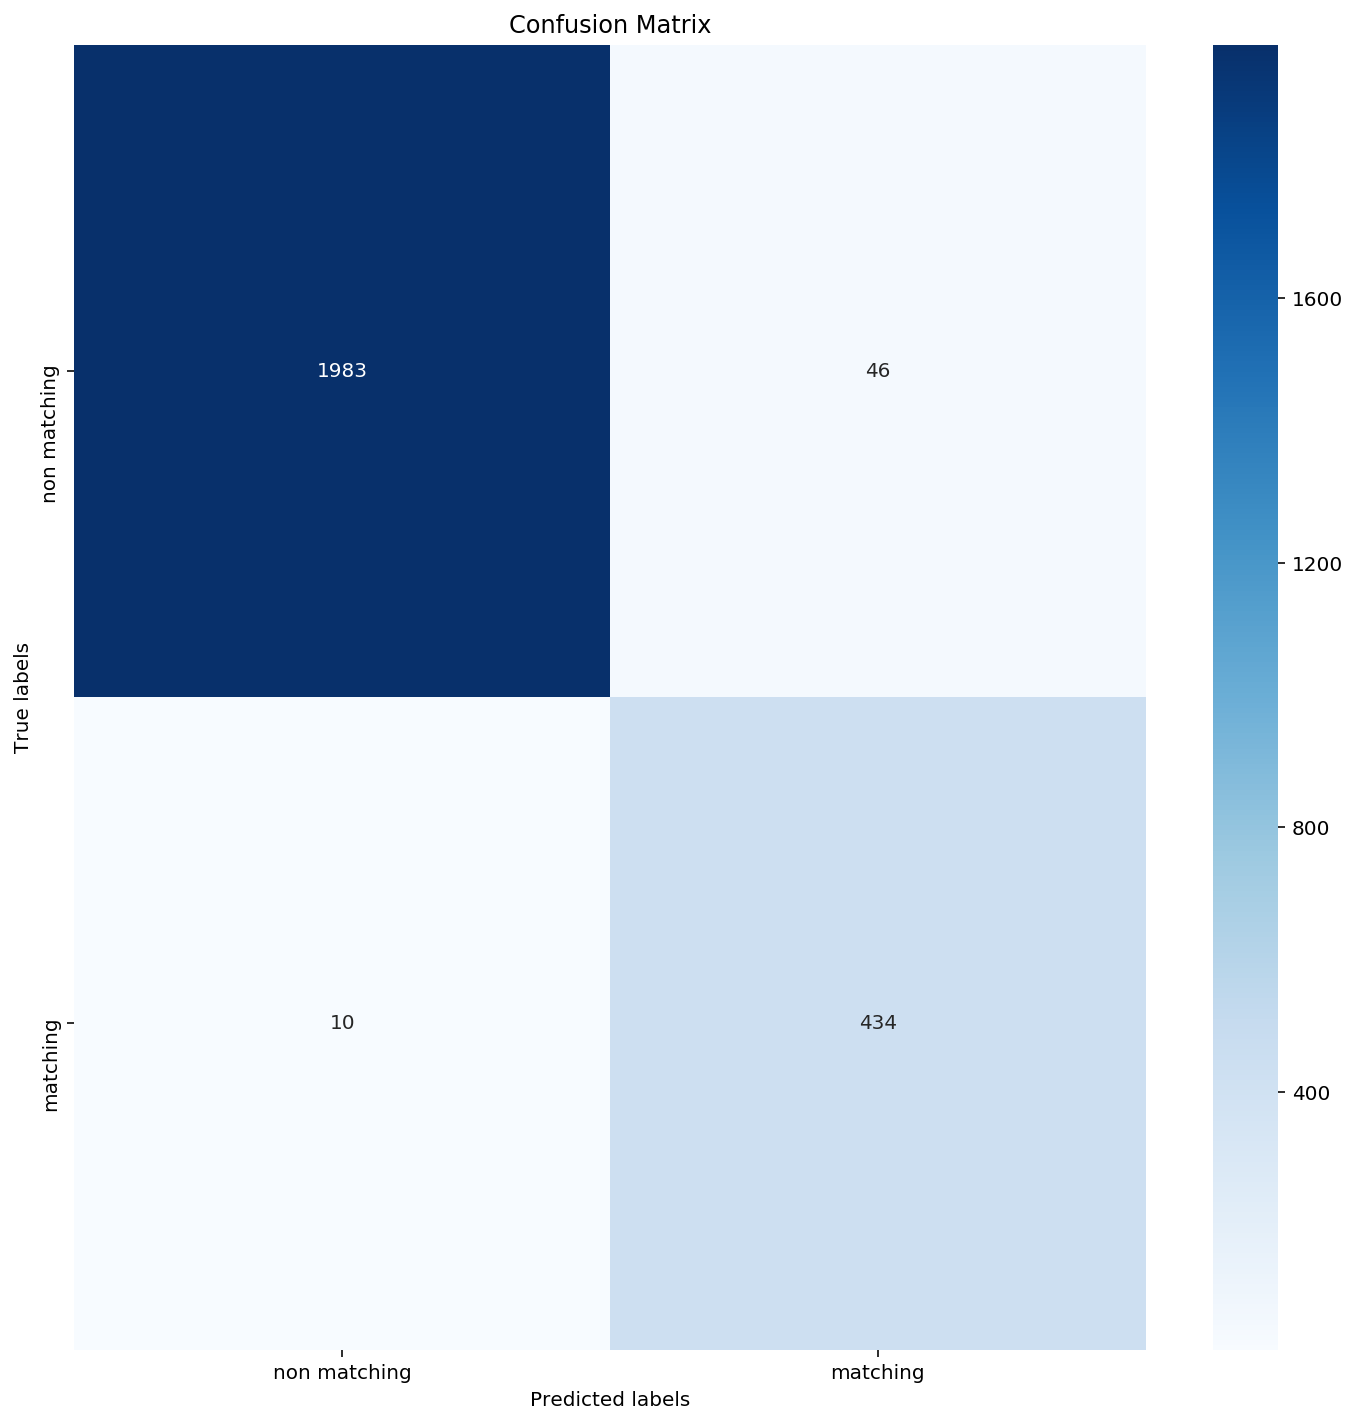

In [15]:
cm = confusion_matrix(testLabels, predictedLabels)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['non matching', 'matching'])
ax.yaxis.set_ticklabels(['non matching', 'matching'])

### Compute metrics

In [16]:
precision, recall, fMeasure, support = precision_recall_fscore_support(testLabels, predictedLabels, average='binary')

if fMeasure is None:
    fMeasure = 0.0
if support is None:
    support = 0.0

row_format ="{:>15}" * 4
print(row_format.format('Precision', 'Recall', 'F-measure', 'Support'))
print(row_format.format(round(precision, 2), round(recall, 2), round(fMeasure,2), round(support, 2)))

      Precision         Recall      F-measure        Support
            0.9           0.98           0.94            0.0
